# OSDI'25 Artifact Evaluation - Plotter

In [1]:
# Prelude
# RUN THIS CELL BEFORE ANYTHING ELSE!

import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir("/mnt/nvme2/PipeANN")

# the process function for PipeANN, DiskANN and Starling.
# Input: the raw log file
# Output: a dict with key: system + dataset + threads, value: list of latency, throughput and recall.
def process_pipeann(filename):
    mode_sysname = ["DiskANN", "Starling", "PipeANN", "Coro", "SPANN", "Vamana"]
    key = ""
    ret = {}
    with open(filename, "r") as f:
        mode = 0
        dataset = ""
        for line in f:
            if line.startswith("[REPORT]"):
                split_line = line.split()
                mode = int(split_line[6])
                threads = split_line[10]
                dataset = split_line[11]
                key = mode_sysname[mode] + "_" + dataset + "_" + threads
                ret[key] = []
            else:
                # data.
                try:
                    split_line = [float(x) for x in line.split()]
                    # QPS, latency, recall, L
                    cur_tuple = (split_line[2], split_line[3] / 1000, split_line[-1] / 100, split_line[0])
                    ret[key].append(cur_tuple)
                except:
                    pass
    return ret

# the process function for SPANN.
# Input: the raw log file
# Output: a dict with key: system + dataset + threads, value: list of latency, throughput and recall.
def process_spann(filename):
    def rdln(f):
        return f.readline().strip()

    ret = {}
    warmup = False
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            split_line = line.split()

            if line.startswith("[REPORT]"):
                split_line = line.split()
                threads = split_line[10]
                dataset = split_line[11]
                key = "SPANN_" + dataset + "_" + threads
                ret[key] = []
            elif ("Start warmup") in line:
                warmup = True
            elif ("Finish warmup") in line:
                warmup = False
            elif line.startswith("[1] Finish sending") and "actuallQPS" in line and not warmup:
                recall_N = 0
                item = [float(split_line[8][:-1])] # qps
                while True:
                    line = rdln(f)
                    if "Recall" in line:
                        recall = float(line.split()[2])
                        item.append(recall) # recall
                        break
                while True:
                    line = rdln(f)
                    if "Total Latency Distribution" in line:
                        while True:
                            line = rdln(f)
                            try:
                                split_line = line.split()
                                if len(split_line) == 8:
                                    item.append(float(split_line[1])) # avg
                                else:
                                    continue
                                break
                            except:
                                pass
                        break
                ret[key].append((item[0], item[2], item[1])) # QPS, lat, recall
    return ret

def process_breakdown(filename):
    sysname_map = {
        "fig16_beam.txt": "Baseline",
        "fig16_pipe1.txt": "+Pipe",
        "fig16_pipe2.txt": "+AlgOpt",
        "fig16_pipe3.txt": "PipeANN",
    }
    key = sysname_map[filename.split("/")[-1]]
    ret = {
        key + "_recall0.9": [],
        key + "_recall0.99": []
    }
    with open(filename, "r") as f:
        mode = 0
        dataset = ""
        for line in f:
            try:
                split_line = [float(x) for x in line.split()]
                # QPS, latency, recall, L
                cur_tuple = (split_line[2], split_line[3] / 1000)
                if split_line[0] < 100:
                    ret[key + "_recall0.9"].append(cur_tuple)
                else:
                    ret[key + "_recall0.99"].append(cur_tuple)
            except:
                pass
    return ret

# for recall-latency and throughput-recall plot.
def reorganize_data(data_array):
    ret = {}
    for data in data_array:
        for k, v in data.items():
            dataset = k.split("_")[1]
            sysname = k.split("_")[0]
            if dataset not in ret:
                ret[dataset] = {}
            ret[dataset][sysname] = v
    return ret

# This function is generated by Gemini 2.5 Pro Preview 03-25. Thanks, Google!
def plot_lat_acc(data, max_lat, min_recall):
    num_datasets = len(data)
    fig, axes = plt.subplots(nrows=1, ncols=num_datasets, figsize=(5 * num_datasets, 4), squeeze=False)

    if num_datasets == 1:
        axes_flat = [axes[0, 0]]
    else:
        axes_flat = axes.flatten()

    for i, (dataset_name, methods_data) in enumerate(data.items()):
        ax = axes_flat[i]
        for method_name, data_points in methods_data.items():
            x_values = [point[1] for point in data_points if len(point) >= 3]
            y_values = [point[2] for point in data_points if len(point) >= 3]

            if x_values:
                sorted_points = sorted(zip(x_values, y_values))
                x_values_sorted, y_values_sorted = zip(*sorted_points)
                ax.plot(x_values_sorted, y_values_sorted, label=method_name, marker='o', linestyle='-')
            else:
                 print(f"No valid points.")

        ax.set_title(f'{dataset_name}')
        ax.set_xlabel('Latency (ms)')
        ax.set_xlim(0, max_lat)
        ax.set_ylabel('Recall 10@10')
        ax.set_ylim(min_recall, 1.01)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    return fig

def plot_tput_acc(data, min_recall):
    num_datasets = len(data)
    fig, axes = plt.subplots(nrows=1, ncols=num_datasets, figsize=(5 * num_datasets, 4), squeeze=False)

    if num_datasets == 1:
        axes_flat = [axes[0, 0]]
    else:
        axes_flat = axes.flatten()

    for i, (dataset_name, methods_data) in enumerate(data.items()):
        ax = axes_flat[i]
        for method_name, data_points in methods_data.items():
            x_values = [point[2] for point in data_points if len(point) >= 3]
            y_values = [point[0] for point in data_points if len(point) >= 3]

            if x_values:
                sorted_points = sorted(zip(x_values, y_values))
                x_values_sorted, y_values_sorted = zip(*sorted_points)
                ax.plot(x_values_sorted, y_values_sorted, label=method_name, marker='o', linestyle='-')
            else:
                 print(f"No valid points.")

        ax.set_title(f'{dataset_name}')
        ax.set_xlabel('Recall 10@10')
        ax.set_xlim(min_recall, 1.01)
        ax.set_ylabel('Throughput (Op/s)')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    return fig

## Figure 11

This figure requires that you run `fig11.sh` beforehand.

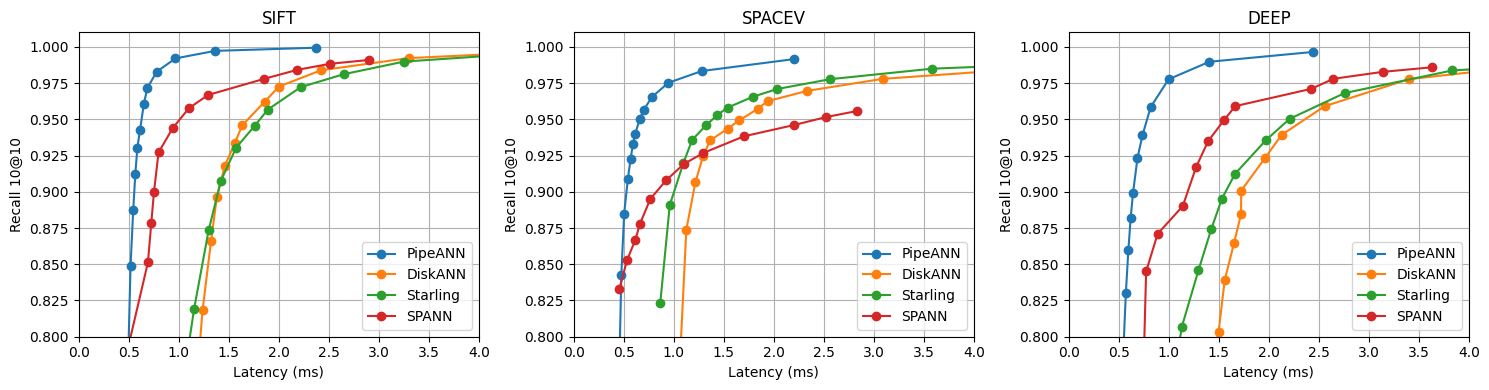

In [2]:
raw_data = [process_pipeann("./data/fig11_pipeann.txt"), process_pipeann("./data/fig11_diskann.txt"), process_pipeann("./data/fig11_starling.txt"), process_spann("./data/fig11_spann.txt")]
plot_data = reorganize_data(raw_data)
f = plot_lat_acc(plot_data, max_lat=4, min_recall=0.8) # enlarge max_lat, shrink min_recall to see the full plot.

## Figure 12

This figure requires that you run `fig12.sh` beforehand.

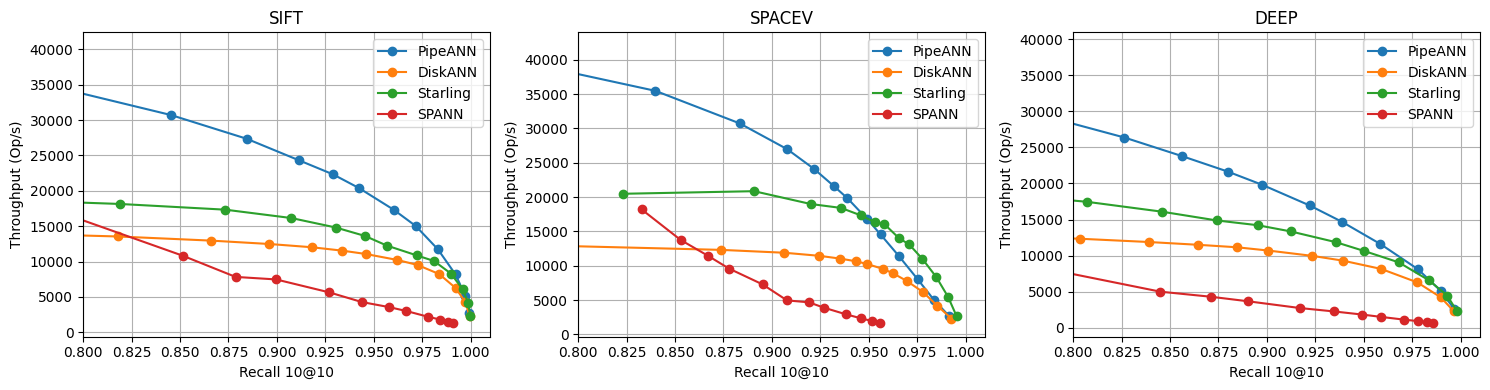

In [3]:
raw_data = [process_pipeann("./data/fig12_pipeann.txt"), process_pipeann("./data/fig12_diskann.txt"), process_pipeann("./data/fig12_starling.txt"), process_spann("./data/fig12_spann.txt")]
plot_data = reorganize_data(raw_data)
f = plot_tput_acc(plot_data, min_recall=0.8) # shrink min_recall to see the full plot.

## Figure 13

This figure requires that you run `fig13.sh` beforehand.

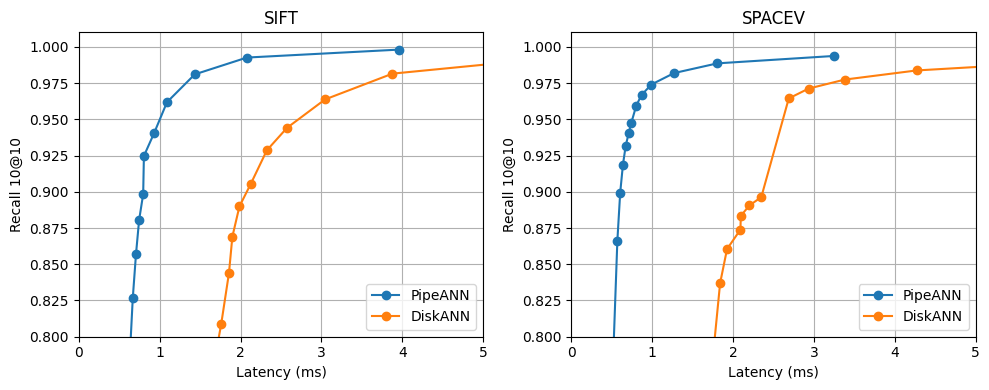

In [4]:
raw_data = [process_pipeann("./data/fig13_pipeann.txt"), process_pipeann("./data/fig13_diskann.txt")]
plot_data = reorganize_data(raw_data)
f = plot_lat_acc(plot_data, max_lat=5, min_recall=0.8) # shrink min_recall to see the full plot.

## Figure 14

This figure requires that you run `fig14.sh` beforehand.

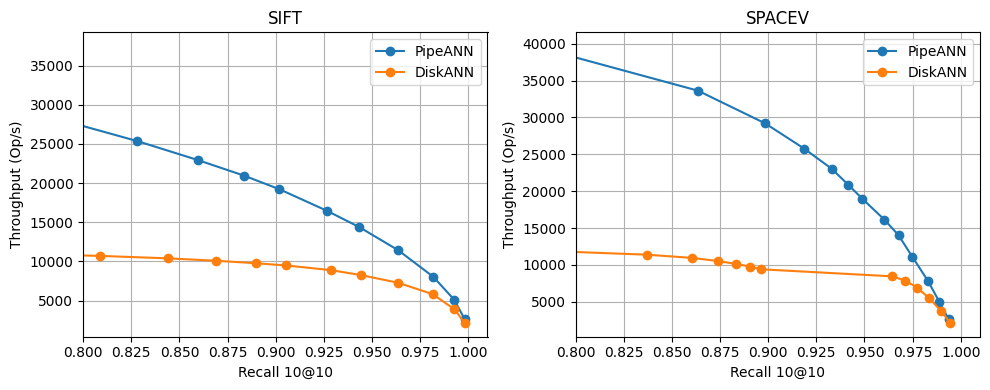

In [5]:
raw_data = [process_pipeann("./data/fig14_pipeann.txt"), process_pipeann("./data/fig14_diskann.txt")]
plot_data = reorganize_data(raw_data)
f = plot_tput_acc(plot_data, min_recall=0.8) # shrink min_recall to see the full plot.

## Figure 15

This figure requires that you run `fig15.sh` beforehand.

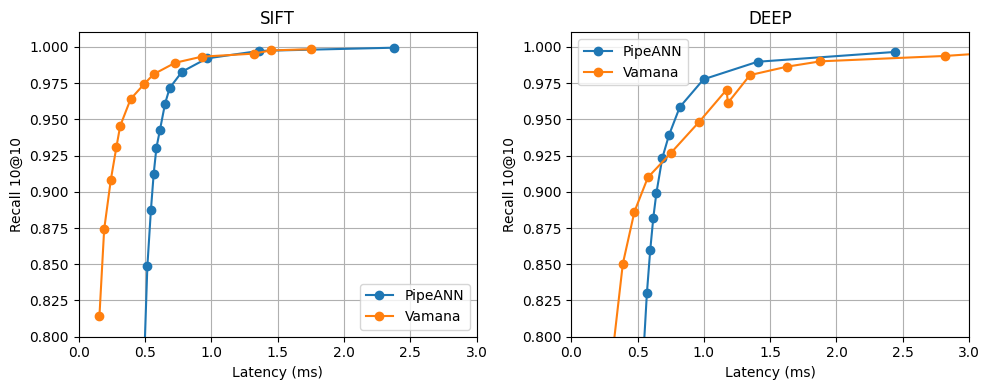

In [6]:
raw_data = [process_pipeann("./data/fig11_pipeann.txt"), process_pipeann("./data/fig15_vamana.txt")]
plot_data = reorganize_data(raw_data)
del plot_data["SPACEV"]
f = plot_lat_acc(plot_data, min_recall=0.8, max_lat=3) # shrink min_recall to see the full plot.

## Figure 16

This figure requires that you run `fig16.sh` beforehand.

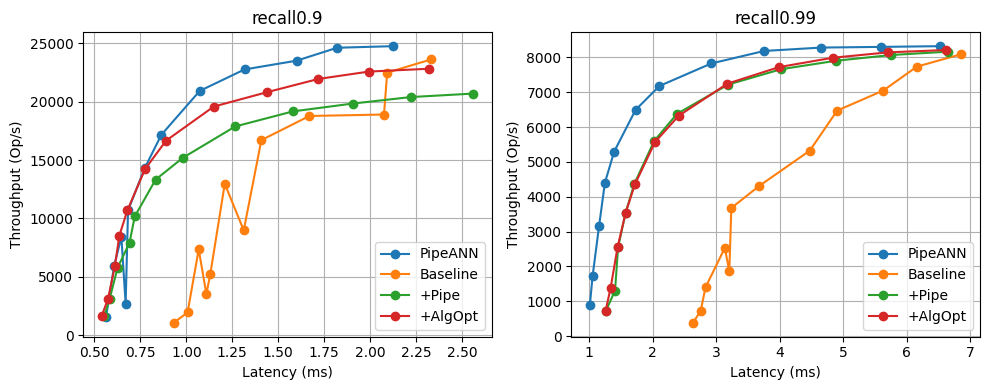

In [7]:
raw_data = [process_breakdown("./data/fig16_pipe3.txt"), process_breakdown("./data/fig16_beam.txt"), process_breakdown("./data/fig16_pipe1.txt"), process_breakdown("./data/fig16_pipe2.txt")]
plot_data = reorganize_data(raw_data)

def plot_lat_tput(data):
    num_datasets = len(data)
    fig, axes = plt.subplots(nrows=1, ncols=num_datasets, figsize=(5 * num_datasets, 4), squeeze=False)

    if num_datasets == 1:
        axes_flat = [axes[0, 0]]
    else:
        axes_flat = axes.flatten()

    for i, (dataset_name, methods_data) in enumerate(data.items()):
        ax = axes_flat[i]
        for method_name, data_points in methods_data.items():
            x_values = [point[1] for point in data_points]
            y_values = [point[0] for point in data_points]

            if x_values:
                sorted_points = sorted(zip(x_values, y_values))
                x_values_sorted, y_values_sorted = zip(*sorted_points)
                ax.plot(x_values_sorted, y_values_sorted, label=method_name, marker='o', linestyle='-')
            else:
                 print(f"No valid points.")

        ax.set_title(f'{dataset_name}')
        ax.set_xlabel('Latency (ms)')
        ax.set_ylabel('Throughput (Op/s)')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    return fig

f = plot_lat_tput(plot_data)

## Figure 17

This figure requires that you run `fig17.sh`, `fig11.sh`, and `fig12.sh` beforehand.

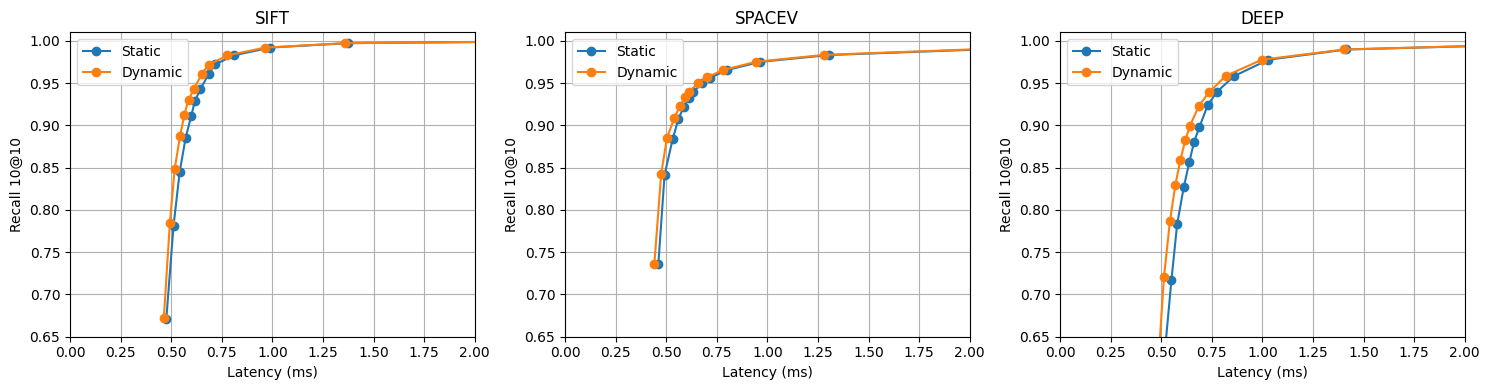

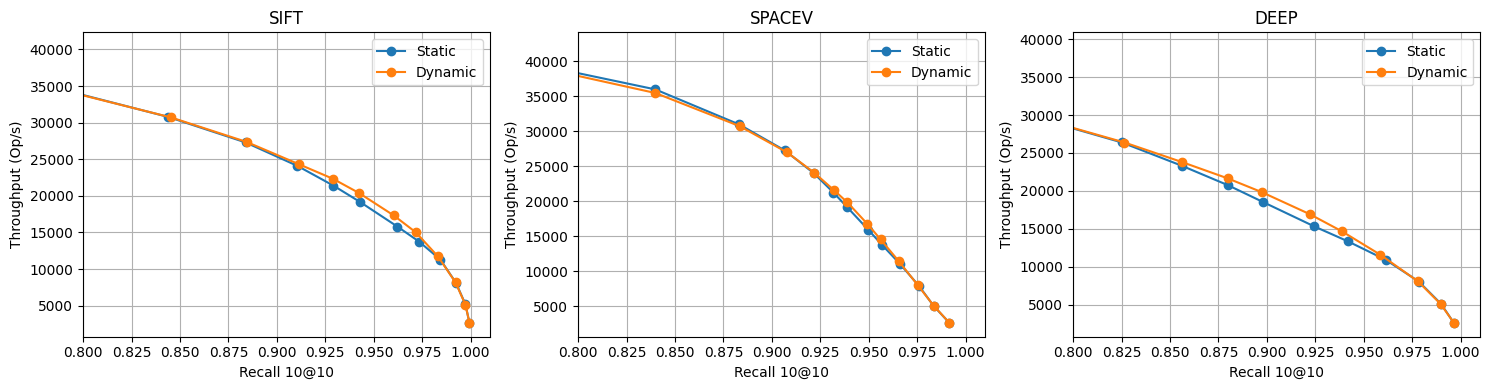

In [8]:
# This draws all the three datasets (6 subgraphs), in Figure 17, only the two first subgraphs are shown.
raw_data_lat = [process_pipeann("./data/fig17_static_lat.txt"), process_pipeann("./data/fig11_pipeann.txt")]
data_lat = [{}, {}]
for k, v in raw_data_lat[0].items():
    re_k = k.replace("PipeANN", "Static")
    data_lat[0][re_k] = v
for k, v in raw_data_lat[1].items():
    re_k = k.replace("PipeANN", "Dynamic")
    data_lat[1][re_k] = v
plot_data_lat = reorganize_data(data_lat)
plot_lat_acc(plot_data_lat, max_lat=2, min_recall=0.65) # shrink min_recall to see the full plot.

raw_data_tput = [process_pipeann("./data/fig17_static_tput.txt"), process_pipeann("./data/fig12_pipeann.txt")]
data_tput = [{}, {}]
for k, v in raw_data_tput[0].items():
    re_k = k.replace("PipeANN", "Static")
    data_tput[0][re_k] = v
for k, v in raw_data_tput[1].items():
    re_k = k.replace("PipeANN", "Dynamic")
    data_tput[1][re_k] = v
plot_data_tput = reorganize_data(data_tput)
f = plot_tput_acc(plot_data_tput, min_recall=0.8) # shrink min_recall to see the full plot.

## Figure 18

This figure requires that you run `fig18.sh` and `fig11.sh` beforehand.

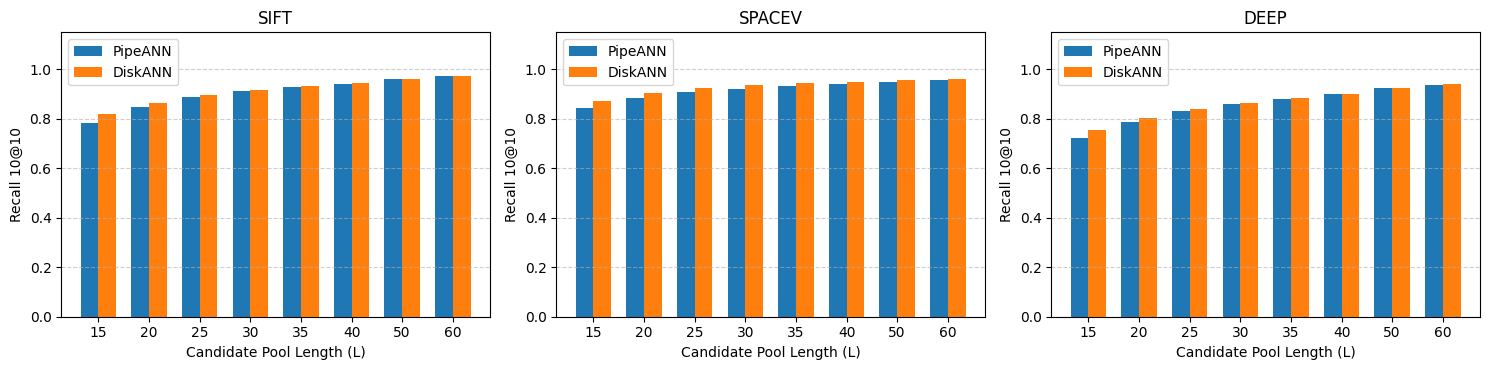

In [9]:
raw_data = [process_pipeann("./data/fig11_pipeann.txt"), process_pipeann("./data/fig11_diskann.txt")]
plot_data = reorganize_data(raw_data)

# This function is generated by Gemini 2.5 Pro Preview 03-25. Thanks, Google!
def plot_recall_L(data, min_L, max_L):
    dataset_names = list(data.keys())
    num_datasets = len(dataset_names)

    if num_datasets == 0:
        print("No datasets found in the input data.")
        return

    # --- Create Figure and Subplots ---
    # Arrange plots in a single row
    ncols = num_datasets
    nrows = 1
    # Adjust figure size dynamically based on number of columns
    # Set a base width per subplot and multiply
    base_width_per_plot = 5 # Adjust as needed
    fig_height = 4          # Adjust as needed
    fig_width = base_width_per_plot * ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height), squeeze=False)
    # `squeeze=False` ensures axes is always a 2D array, even if nrows/ncols is 1
    # Flatten the axes array for easy iteration
    axes_flat = axes.flatten()

    # Indices for Recall (Y) and Parameter L (X)
    y_index = 2
    x_index = 3

    # --- Loop through datasets and plot on corresponding axes ---
    for i, dataset_name in enumerate(dataset_names):
        current_ax = axes_flat[i] # Get the axes for the current dataset
        methods_data = data[dataset_name]
        pipeann_raw = methods_data.get('PipeANN', [])
        diskann_raw = methods_data.get('DiskANN', [])

        # Filter data based on max_L and tuple length validity
        pipeann_filtered = [item for item in pipeann_raw if len(item) > max(x_index, y_index) and item[x_index] <= max_L and item[x_index] >= min_L]
        diskann_filtered = [item for item in diskann_raw if len(item) > max(x_index, y_index) and item[x_index] <= max_L and item[x_index] >= min_L]

        # Prepare data for plotting (unique L values, aligned Y values)
        all_L_values = set(item[x_index] for item in pipeann_filtered) | set(item[x_index] for item in diskann_filtered)
        sorted_L_values = sorted(list(all_L_values))

        pipeann_dict = {item[x_index]: item[y_index] for item in pipeann_filtered}
        diskann_dict = {item[x_index]: item[y_index] for item in diskann_filtered}

        pipeann_y = [pipeann_dict.get(L, 0) for L in sorted_L_values]
        diskann_y = [diskann_dict.get(L, 0) for L in sorted_L_values]

        # Plotting on the current axes (current_ax)
        x_pos = np.arange(len(sorted_L_values))
        width = 0.35

        rects1 = current_ax.bar(x_pos - width/2, pipeann_y, width, label='PipeANN', color='tab:blue')
        rects2 = current_ax.bar(x_pos + width/2, diskann_y, width, label='DiskANN', color='tab:orange')

        # Add labels, title, and ticks for the current subplot
        current_ax.set_ylabel(f'Recall 10@10')
        current_ax.set_xlabel(f'Candidate Pool Length (L)')
        current_ax.set_title(dataset_name)

        x_tick_labels = [str(int(L)) if isinstance(L,(int,float)) and L == int(L) else str(L)
                         for L in sorted_L_values]
        current_ax.set_xticks(x_pos)
        current_ax.set_xticklabels(x_tick_labels) # Rotate labels if needed
        current_ax.legend()
        current_ax.set_ylim(0, 1.15)

        current_ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    fig.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent overlap, leave space for suptitle
    return fig # Show the entire figure with all subplots
f = plot_recall_L(plot_data, min_L=15, max_L=60)